# Big Data Assignment for Linear Regression

- Name : Abidjanna Zulfa Hamdika
- Student ID : 5025201197
- Class : Big Data A

Source : https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

Data Source : https://www.kaggle.com/c/boston-housing/data?select=train.csv 

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Data

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('./train.csv')
house_df.take(1)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

# Data Exploration

In [4]:
house_df.cache()
house_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [5]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.8594378018597,1,506
crim,333,3.3603414714714708,7.352271836781104,0.00632,73.5341
zn,333,10.68918918918919,22.674761796618217,0.0,100.0
indus,333,11.29348348348346,6.998123104477312,0.74,27.74
chas,333,0.06006006006006006,0.2379556428164483,0,1
nox,333,0.557144144144145,0.11495450830289312,0.385,0.871
rm,333,6.265618618618616,0.7039515757334471,3.561,8.725
age,333,68.22642642642641,28.13334360562338,6.0,100.0
dis,333,3.7099336336336335,1.9811230514407001,1.1296,10.7103


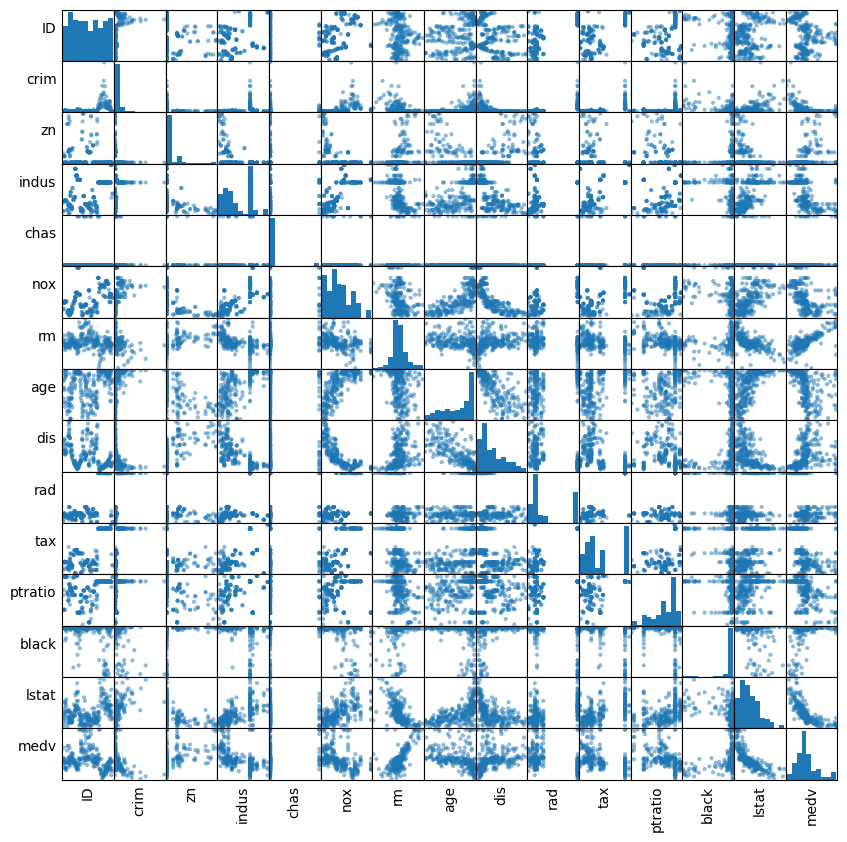

In [7]:
import pandas as pd
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [9]:
import six
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('medv',i))

Correlation to MV for  ID -0.22169418651611697
Correlation to MV for  crim -0.4074543235732598
Correlation to MV for  zn 0.34484197569664277
Correlation to MV for  indus -0.47393197065920345
Correlation to MV for  chas 0.20438998859918733
Correlation to MV for  nox -0.4130541519920783
Correlation to MV for  rm 0.6895980892872156
Correlation to MV for  age -0.35888827406190227
Correlation to MV for  dis 0.24942226829396397
Correlation to MV for  rad -0.3522508242456341
Correlation to MV for  tax -0.44807769440070433
Correlation to MV for  ptratio -0.48137595552491735
Correlation to MV for  black 0.33665955532155767
Correlation to MV for  lstat -0.7386000348786346
Correlation to MV for  medv 1.0


In [12]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.03237,0.0,2.18...|33.4|
+--------------------+----+
only showing top 3 rows



In [13]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

# Linear Regression

In [15]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.013585169673472203,0.0,4.771927756827384,-0.8441124775352372,4.092276336763626,0.0,-0.5262567450245833,0.0144528866445977,0.0,-0.756069642763986,0.011332267156700274,-0.6250191303863244]
Intercept: 16.467618462224035


In [16]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.778611
r2: 0.726142


In [17]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               230|
|   mean|22.512173913043476|
| stddev| 9.151358481979166|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [20]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 27.22413873009023|22.0|[0.01096,55.0,2.2...|
| 30.45743350675032|35.4|[0.01311,90.0,1.2...|
| 43.68879045673252|50.0|[0.01501,90.0,1.2...|
|31.352600414241316|32.9|[0.01778,95.0,1.4...|
|26.429911918299926|23.1|[0.0187,85.0,4.15...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.656037


In [21]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5.39367


In [22]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.5, 0.43408093409382126, 0.24325079071863112, 0.2149448386216658, 0.1817393920787754, 0.17625803616504548, 0.1747760792470994, 0.17409445260515283, 0.17404097115734157, 0.1739092053924528, 0.17381757307545084]
+--------------------+
|           residuals|
+--------------------+
|  -6.844114748028922|
|  1.6735628251994257|
|  0.8642501701603571|
|   2.178515451356784|
|-0.03041359003285038|
| -1.3475737221361328|
| -3.3394098731324675|
|    7.02259846609649|
| 0.11533200341561667|
|  10.839709911690889|
| -1.7025525612915722|
| 0.06769365710712094|
| -10.001518035182684|
| -4.0671566168491395|
| 0.32529283356930705|
|  1.3852202469499453|
|  2.4199724170535077|
| -0.9698157039598421|
| -3.7881620021237694|
|  10.636408764144946|
+--------------------+
only showing top 20 rows



In [25]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 27.22413873009023|22.0|[0.01096,55.0,2.2...|
| 30.45743350675032|35.4|[0.01311,90.0,1.2...|
| 43.68879045673252|50.0|[0.01501,90.0,1.2...|
|31.352600414241316|32.9|[0.01778,95.0,1.4...|
|26.429911918299926|23.1|[0.0187,85.0,4.15...|
| 25.09023430526122|21.6|[0.02731,0.0,7.07...|
| 29.26200959204246|30.8|[0.02763,75.0,2.9...|
| 26.85155144034796|25.0|[0.02875,28.0,15....|
|30.067843797456813|33.4|[0.03237,0.0,2.18...|
|22.265459313594995|20.6|[0.03306,0.0,5.19...|
| 30.54964940292052|28.5|[0.03502,80.0,4.9...|
| 28.74805736049886|27.9|[0.03615,80.0,4.9...|
|31.586957109299178|30.3|[0.04666,80.0,1.5...|
|23.926240388799233|23.4|[0.04981,21.0,5.6...|
|27.556045377270976|27.1|[0.05372,0.0,13.9...|
| 34.67207892995108|50.0|[0.05602,0.0,2.46...|
|31.063999508204507|37.2|[0.0578,0.0,2.46,...|
| 40.87862441173853|46.0|[0.06129,20.0,3.3...|
|24.195130733

# Decision Tree Regressor

In [27]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.66721


In [28]:
dt_model.featureImportances

SparseVector(13, {0: 0.0299, 3: 0.019, 5: 0.6036, 7: 0.0938, 9: 0.0111, 10: 0.027, 11: 0.0064, 12: 0.2092})

In [29]:
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

# Gradient Tree Regressor

In [31]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|20.731730811489978|22.0|[0.01096,55.0,2.2...|
| 33.29752152691914|35.4|[0.01311,90.0,1.2...|
|49.694274471417444|50.0|[0.01501,90.0,1.2...|
| 35.19444751736853|32.9|[0.01778,95.0,1.4...|
|23.218292620097998|23.1|[0.0187,85.0,4.15...|
+------------------+----+--------------------+
only showing top 5 rows



In [33]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.57968


# Summary

Gradient Tree Regressor with 4.57968 RMSE score performed best on data